In [1]:
%matplotlib inline

import fs
import PIL
from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import gc

try:
    import cPickle as pickle
except:
    import pickle

DATA_DIR = '../data'

WIKI_CROPS_DIR = "wiki_crop"
IMDB_CROPS_DIR = "imdb_crop"

WIKI_META_OBJ = 'wiki_meta.obj'
IMDB_META_OBJ = 'imdb_meta.obj'

TRAIN_DATA_OBJ = 'packaged/train_data'
VAL_DATA_OBJ = 'packaged/val_data'
TEST_DATA_OBJ = 'packaged/test_data'

TRAIN_MEAN_OBJ = 'packaged/mean.obj'

np.random.seed(42)

In [11]:
lmap = lambda f, l: list(map(f, l))
lfilter = lambda f, l: list(filter(f, l))

def merge_meta_data(data1, data2):
    return {
        'path':   np.append(data1['path'], data2['path']),
        'name':   np.append(data1['name'], data2['name']),
        'age':    np.append(data1['age'], data2['age']),
        'gender': np.append(data1['gender'], data2['gender']),
    }

def filter_meta_data(data, filter_mask):
    return {
        'path':   data['path'][filter_mask].reshape(-1),
        'name':   data['name'][filter_mask].reshape(-1),
        'age':    data['age'][filter_mask].reshape(-1),
        'gender': data['gender'][filter_mask].reshape(-1),
    }

def shuffle_meta_data(data):
    idx = np.arange(len(data['age']))
    rand_idx = np.random.shuffle(idx)
    return filter_meta_data(data, rand_idx)

def split_meta_data(data, f=0.1):
    intermediate = int(float(len(data['age'])) * f)
    idx1 = np.arange(intermediate)
    idx2 = np.arange(intermediate, len(data['age']))
    return filter_meta_data(data, idx1), filter_meta_data(data, idx2)

def to_bins(data, bins):
    bin_labels = lmap(lambda b: '%s-%s' % b, bins)
    binarize = lambda x: bins.index(next(filter(lambda e: x >= e[0] and x <= e[1], bins)))
    binarize_vec = np.vectorize(binarize)
    return binarize_vec(data), bin_labels
    
def plot_histo(data, bins=30, range=(0,100), figsize=(4,2), xticks=None, xlabel=None, ylabel=None, title=None, xticks_rotation=None):
    hist, bin_edges = np.histogram(data, bins=bins, range=range)

    plt.figure(figsize=figsize)
    plt.bar(bin_edges[:-1], hist, width=1)
    plt.xlim(min(bin_edges), max(bin_edges))
    if xticks is not None:
        plt.xticks(np.arange(len(xticks)) + 0.5, xticks, rotation=xticks_rotation)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.show()

# Load combined data

In [12]:
with open(fs.join(DATA_DIR, WIKI_META_OBJ), 'rb') as file:
    wiki_meta = pickle.load(file)
    
with open(fs.join(DATA_DIR, IMDB_META_OBJ), 'rb') as file:
    imdb_meta = pickle.load(file)

meta_all = merge_meta_data(imdb_meta, wiki_meta)

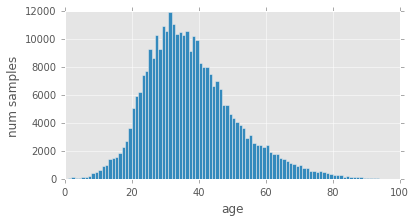

In [13]:
plot_histo(meta_all['age'], bins=100, figsize=(6,3), xlabel='age', ylabel='num samples')

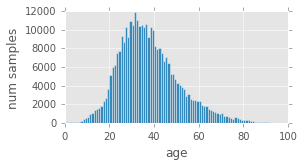

In [14]:
plot_histo(meta_all['age'], bins=100, xlabel='age', ylabel='num samples')

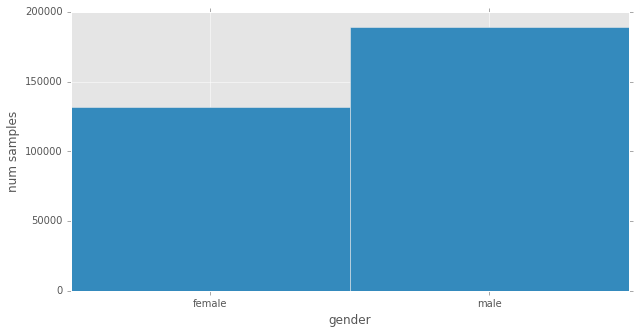

In [15]:
plot_histo(meta_all['gender'], bins=(0,1,2), xticks=['female', 'male'], figsize=(10,5), xlabel='gender', ylabel='num samples')

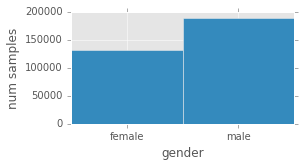

In [16]:
plot_histo(meta_all['gender'], bins=(0,1,2), xticks=['female', 'male'], xlabel='gender', ylabel='num samples')

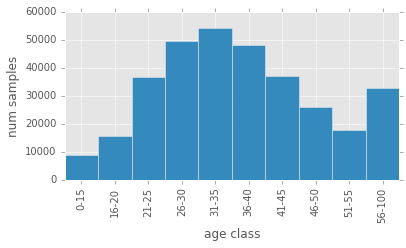

In [17]:
age_classes = [(0,15),(16,20),(21,25),(26,30),(31,35),(36,40),(41,45),(46,50),(51,55),(56,100)]

age_binned, age_labels = to_bins(meta_all['age'], age_classes)

plot_histo(age_binned, bins=range(len(age_labels) + 1), figsize=(6,3), xticks=age_labels, xlabel='age class', ylabel='num samples', xticks_rotation='vertical')

In [18]:
meta_all_shuffled = shuffle_meta_data(meta_all)

train, test = split_meta_data(meta_all_shuffled, 0.8)
train, val = split_meta_data(train, 0.9)

# Free some memory
del wiki_meta
del imdb_meta
del meta_all
del meta_all_shuffled
gc.collect()

47026

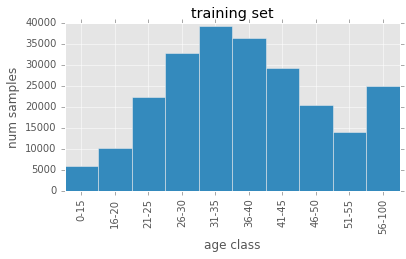

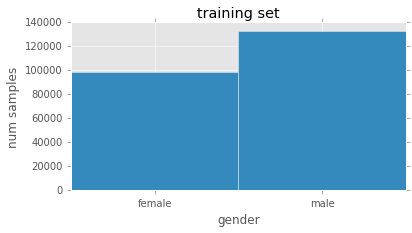

In [25]:
age_binned, age_labels = to_bins(train['age'], age_classes)
plot_histo(age_binned, bins=range(len(age_labels) + 1), xticks=age_labels, figsize=(6,3),
           xlabel='age class', ylabel='num samples', xticks_rotation='vertical', title='training set')
plot_histo(train['gender'], bins=(0,1,2), xticks=['female', 'male'], xlabel='gender', ylabel='num samples',
          figsize=(6,3), title='training set')

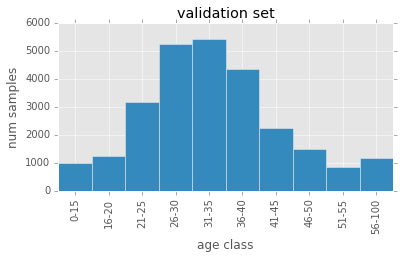

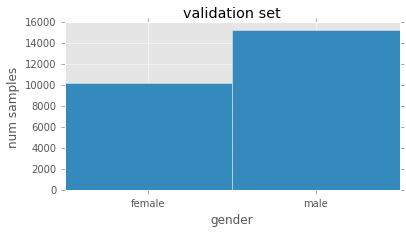

In [26]:
age_binned, age_labels = to_bins(val['age'], age_classes)
plot_histo(age_binned, bins=range(len(age_labels) + 1), xticks=age_labels, figsize=(6,3),
           xlabel='age class', ylabel='num samples', xticks_rotation='vertical', title='validation set')
plot_histo(val['gender'], bins=(0,1,2), xticks=['female', 'male'], xlabel='gender', ylabel='num samples',
          figsize=(6,3), title='validation set')

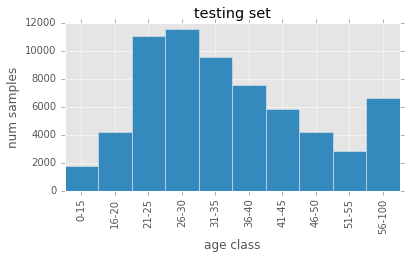

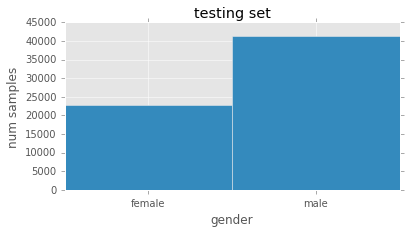

In [27]:
age_binned, age_labels = to_bins(test['age'], age_classes)
plot_histo(age_binned, bins=range(len(age_labels) + 1), xticks=age_labels, figsize=(6,3),
           xlabel='age class', ylabel='num samples', xticks_rotation='vertical', title='testing set')
plot_histo(test['gender'], bins=(0,1,2), xticks=['female', 'male'], xlabel='gender', ylabel='num samples',
          figsize=(6,3), title='testing set')

In [11]:
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

def get_img_array(meta_data, img_dim=(3,224,224), split=0, num_samples_per_split=100000, dtype=np.float32):
    i_start = min(split * num_samples_per_split, len(meta_data['path']))
    i_stop = min(split * num_samples_per_split + num_samples_per_split, len(meta_data['path']))
    num_samples = i_stop - i_start
    
    X = np.zeros((num_samples,img_dim[0],img_dim[1],img_dim[2]), dtype=dtype)
    y_age = np.zeros((num_samples))
    y_gender = np.zeros((num_samples))
    
    print('Allocating %s for dataset with shape (%i,%i,%i,%i)' %
          (sizeof_fmt(X.nbytes), num_samples, img_dim[0], img_dim[1], img_dim[2]))
    
    age_class = lambda x: age_classes.index(next(filter(lambda e: x >= e[0] and x <= e[1], age_classes)))
    
    for i in range(i_start, i_stop):
        y_age[i - i_start] = age_class(meta_data['age'][i])
        y_gender[i - i_start] = meta_data['gender'][i]
        abspath = fs.join(DATA_DIR, meta_data['path'][i])
        with Image.open(abspath) as img:
            # Rescale and convert to greyscale
            # PIL.Image.LANCZOS - a high-quality downsampling filter
            # PIL.Image.BICUBIC - cubic spline interpolation
            img = img.resize(img_dim[1:3], PIL.Image.LANCZOS).convert('RGB')
            X[i - i_start] = np.asarray(img, dtype=dtype).reshape((img_dim)) / 255
    return X, y_age, y_gender

In [12]:
# Define the number of samples per split
num_samples_per_split = 25000
img_dim = (3,112,112)

In [13]:
X_mean = np.zeros(img_dim)

print("%i Sapmles. %i Blocks required" % (len(train['path']), math.ceil(len(train['path']) / num_samples_per_split)))

for i in range(math.ceil(len(train['path']) / num_samples_per_split)):
    X_train, y_age, y_gender = get_img_array(train, img_dim=img_dim, split=i, num_samples_per_split=num_samples_per_split)
    np.save(fs.add_suffix(fs.join(DATA_DIR, TRAIN_DATA_OBJ), '_%02d' % i), X_train)
    np.save(fs.add_suffix(fs.join(DATA_DIR, TRAIN_DATA_OBJ), '_label_age_%02d' % i), y_age)
    np.save(fs.add_suffix(fs.join(DATA_DIR, TRAIN_DATA_OBJ), '_label_gender_%02d' % i), y_gender)
    
    X_mean += X_train.sum(axis=0) / (img_dim[0] * img_dim[1] * img_dim[2])
    
    # Remove the array from memory
    del X_train
    gc.collect()

235405 Sapmles. 10 Blocks required
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 1.5GiB for dataset with shape (10405,3,112,112)


In [14]:
X_mean /= len(train['path'])
np.save(fs.join(DATA_DIR, TRAIN_MEAN_OBJ), X_mean)

In [15]:
# RGB mean
X_mean.mean(axis=(1,2))

array([  9.97129637e-06,   1.08412396e-05,   9.84627021e-06])

In [16]:
print("%i Sapmles. 1 Block forced" % (len(val['path'])))

X_val, y_age, y_gender = get_img_array(val, img_dim=img_dim, num_samples_per_split=len(val['path']))
np.save(fs.join(DATA_DIR, VAL_DATA_OBJ), X_val)
np.save(fs.add_suffix(fs.join(DATA_DIR, VAL_DATA_OBJ), '_label_age'), y_age)
np.save(fs.add_suffix(fs.join(DATA_DIR, VAL_DATA_OBJ), '_label_gender'), y_gender)

del X_val
gc.collect()

26157 Sapmles. 1 Block forced
Allocating 3.7GiB for dataset with shape (26157,3,112,112)


0

In [17]:
print("%i Sapmles. %i Blocks required" % (len(test['path']), math.ceil(len(test['path']) / num_samples_per_split)))

for i in range(math.ceil(len(test['path']) / num_samples_per_split)):
    X_test, y_age, y_gender = get_img_array(test, img_dim=img_dim, split=i, num_samples_per_split=num_samples_per_split)
    np.save(fs.add_suffix(fs.join(DATA_DIR, TEST_DATA_OBJ), '_%02d' % i), X_test)
    np.save(fs.add_suffix(fs.join(DATA_DIR, TEST_DATA_OBJ), '_label_age_%02d' % i), y_age)
    np.save(fs.add_suffix(fs.join(DATA_DIR, TEST_DATA_OBJ), '_label_gender_%02d' % i), y_gender)
    # Remove the array from memory
    del X_test
    gc.collect()

65391 Sapmles. 3 Blocks required
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 3.5GiB for dataset with shape (25000,3,112,112)
Allocating 2.2GiB for dataset with shape (15391,3,112,112)
